In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

#get the cifar-10 dataset from Kaggle
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
#put 10,000 images from the train set into a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.2, random_state= 8)

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
#confirm that the train, validaiton, and test set split is 40,0000 / 10,000 / 10,000 
print("X train shape: ", X_train.shape)
print("X val shape: ", X_test.shape)
print("X test shape: ", X_test.shape)

X train shape:  (40000, 32, 32, 3)
X val shape:  (10000, 32, 32, 3)
X test shape:  (10000, 32, 32, 3)


In [ ]:
#convert y test/val/train to a 1D array, since it doesn't need to be 2D
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
y_val = y_val.reshape(-1)

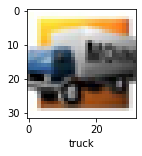

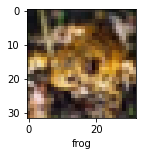

In [ ]:
#plot a few of the images
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])
  
plot_sample(X_train, y_train, 1)
plot_sample(X_train, y_train, 5)

In [ ]:
#Normalize the data. Since it is so simple (on a scale from 0 to 255), we don't need to use a min-max scaler. All we need to do is divide by 255. 
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout

#function that allows us to build models with different hyperparameter values
def build_model(hp):   
    model = models.Sequential()
    
    #first convolutional layer
    model.add(Conv2D(hp.Int("conv_1_filter", min_value=32, max_value= 128, step=16), 
                     kernel_size=hp.Choice('conv_1_kernel', values=[2,5]), 
                     input_shape=(32, 32, 3),
                     padding='same',
                     activation='relu'))
    
    #first pooling and dropout layers
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))

    #second convolutional layer
    model.add(Conv2D(hp.Int("conv_2_filter", min_value=32, max_value= 128, step=16), 
                  kernel_size=hp.Choice('conv_2_kernel', values=[2,5]), 
                  input_shape=(32, 32, 3),
                  padding='same',
                  activation='relu'))  
      
    #second pooling and dropout layers
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))   

   #flatten the data before it gets fed to the dense layers
    model.add(Flatten()) 

    #first dense layer
    model.add(Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='softmax'))
    
    #second dense layer (output layer)
    model.add(Dense(10, activation = 'softmax'))
   

    #compile the model
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model


In [ ]:
tuner = RandomSearch(
    build_model,    
    objective='val_accuracy',
    max_trials=1,  # how many model variations to test
    executions_per_trial=1,  # how many trials per variation
    directory='CNN',
    project_name='CNN_Project',
    overwrite=True)

In [ ]:
tuner.search(x=X_train,
             y=y_train,            
             epochs=10,
             batch_size=128,
             verbose=2,
             validation_data=(X_val, y_val))

Trial 1 Complete [00h 00m 42s]
val_accuracy: 0.6772000193595886

Best val_accuracy So Far: 0.6772000193595886
Total elapsed time: 00h 00m 42s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#get the best model from our last search
print(tuner.get_best_hyperparameters()[0].values)

{'conv_1_filter': 64, 'conv_1_kernel': 2, 'conv_2_filter': 112, 'conv_2_kernel': 2, 'dense_1_units': 112}


In [ ]:
#this builds a model using the optimal hyperparameters found
model = models.Sequential()
    
model.add(Conv2D(filters=64, 
          kernel_size=(2,2), 
          input_shape=(32, 32, 3),
          padding='same',
          activation='relu'))
    
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
    
    
model.add(Conv2D(filters=32, 
          kernel_size=(2,2), 
          input_shape=(32, 32, 3),
          padding='same',
          activation='relu'))    
    
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))   

model.add(Flatten()) 

model.add(Dense(32, activation='relu')  )  
model.add(Dense(10, activation = 'softmax'))
   

model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 32)         

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size = 128, validation_data=(X_val, y_val))

Epoch 1/30
313/313 [==============================] - 6s 18ms/step - loss: 1.8815 - accuracy: 0.3204 - val_loss: 1.6137 - val_accuracy: 0.4365
Epoch 2/30
313/313 [==============================] - 5s 16ms/step - loss: 1.5041 - accuracy: 0.4625 - val_loss: 1.4031 - val_accuracy: 0.4981
Epoch 3/30
313/313 [==============================] - 5s 17ms/step - loss: 1.3510 - accuracy: 0.5187 - val_loss: 1.3020 - val_accuracy: 0.5325
Epoch 4/30
313/313 [==============================] - 5s 17ms/step - loss: 1.2679 - accuracy: 0.5531 - val_loss: 1.2056 - val_accuracy: 0.5802
Epoch 5/30
313/313 [==============================] - 5s 17ms/step - loss: 1.2063 - accuracy: 0.5748 - val_loss: 1.1314 - val_accuracy: 0.6040
Epoch 6/30
313/313 [==============================] - 5s 17ms/step - loss: 1.1576 - accuracy: 0.5932 - val_loss: 1.1084 - val_accuracy: 0.6141
Epoch 7/30
313/313 [==============================] - 5s 17ms/step - loss: 1.1147 - accuracy: 0.6078 - val_loss: 1.0601 - val_accuracy: 0.6273

In [ ]:
#get the test set predictions, calculate the accuracy
pred = model.predict(X_test)
pred = [np.argmax(element) for element in pred]
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.6923

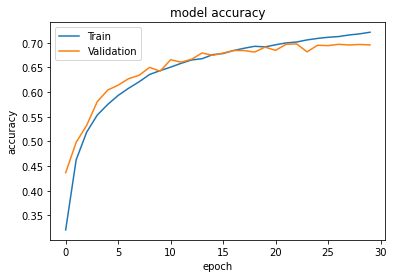

In [ ]:
#plot the accuracy of the train and validation set over the last n epochs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

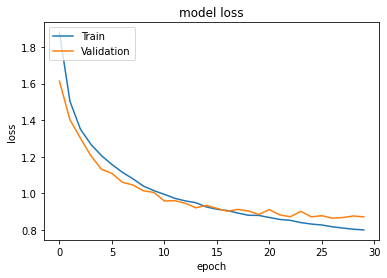

In [ ]:
#plot the loss of the train and validation set over the last n epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()